# Random Forest Workbook

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
df = pd.read_csv('immo-ml-data.csv')
df.head

<bound method NDFrame.head of        Type   Price  Bedrooms  Is_Equiped_Kitchen  State  Facades  Swim_pool  \
0         1  329000         2                   1      1        3          0   
1         1  180000         3                   0      3        2          1   
2         1  369000         6                   0      5        3          1   
3         1  145000         2                   1      1        2          0   
4         1  269000         3                   1      1        2          0   
...     ...     ...       ...                 ...    ...      ...        ...   
10480     0  324146         2                   0      1        0          0   
10481     0  699000         4                   0      3        0          0   
10482     0  950000         2                   0      3        2          0   
10483     0  562500         3                   0      1        0          0   
10484     0  305000         2                   1      1        0          0   

       Mu

## Seperate featues and Target

In [131]:
X = df.drop(columns=['Price']) # Features
y = df['Price'] # Target

## Train/Test Split

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

(8388, 13)
(8388,)


## Train model

In [133]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [134]:
train_score = model.score(X_train, y_train) * 100
test_score = model.score(X_test, y_test) * 100
print(f"Training Score: {train_score:.2f}")
print(f"Test Score: {test_score:.2f}")

Training Score: 92.53
Test Score: 56.21


## Make Predictions

In [135]:
y_pred = model.predict(X_test)

print("Predicted values:", y_pred)

print("Actual values:", y_test)

Predicted values: [236210.         314655.         441454.24333333 ... 290888.66666667
 293415.51       246808.9       ]
Actual values: 4309    379000
8444    239000
4184    314000
9306    295000
1112    376000
         ...  
3544    299000
9294    370000
9114    270000
6225    460000
3826    235000
Name: Price, Length: 2097, dtype: int64


## Fine-tune Model

Going to try grid search to get the best parameters.

In [ ]:
# Parameters to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Do grid search
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           verbose=2,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [ ]:
print("Best Parameters:", grid_search.best_params_)

print(best_model)

print("Best R2 Score:", grid_search.best_score_)


Grid takes 15 min to run.

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)
Best R2 Score: 0.5289334352937849

## Evaluate Best Model

In [ ]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

## Feature Importance

In [136]:
importances = model.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

               Feature  Importance
2          Living_Area    0.432824
12              Region    0.137204
6         Terrace_Area    0.104210
9                State    0.098598
1             Bedrooms    0.055565
10             Facades    0.049941
8          Garden_Area    0.036872
3   Is_Equiped_Kitchen    0.025721
0                 Type    0.024260
11           Swim_pool    0.017258
5              Terrace    0.007625
7               Garden    0.005245
4         Is_Open_Fire    0.004676


Based on this I'm going to drop:

- **Garden** and **Terrace**: They are redundant and the area columns have more predictive power.
- **Is_Open_Fire**: Least amount of predictive power.

In [137]:
df = df.drop(columns=['Garden', 'Terrace', 'Is_Open_Fire'])

## Retrain model and Test Again

In [ ]:
best_model = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_train, y_train)

In [138]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Garden
- Is_Equiped_Kitchen
- Is_Open_Fire
- Swim_pool
- Terrace
- ...


In [139]:
df = df.drop(columns=['Is_Equiped_Kitchen', 'Type', 'Swim_pool'])

In [140]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [141]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Root Mean Squared Error: 119698.56637859395
R² Score: 0.5674948123226193


Root Mean Squared Error: 119698.56637859395

R² Score: 0.5674948123226193 (After dropping columns)

Removing all Columns with less than 3% feature importance. Minimal improvement on R² score.

## Feature Engineering


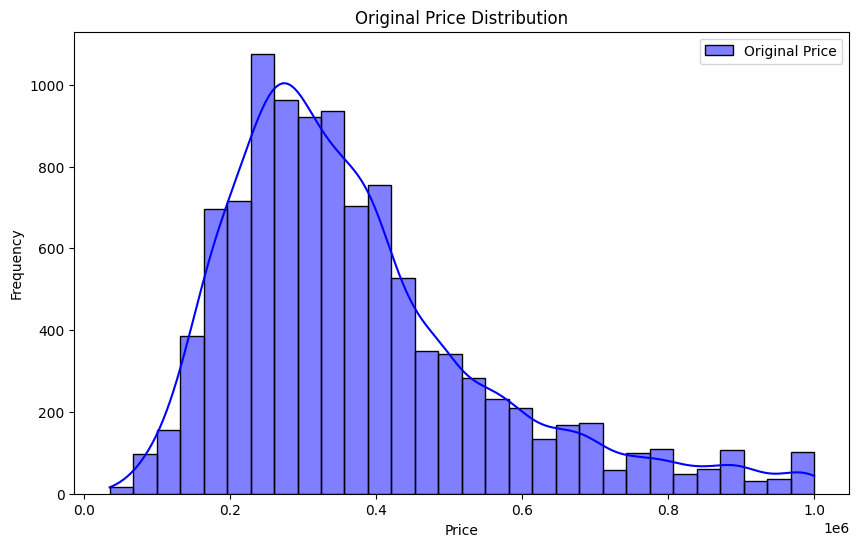

In [142]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=30, color='blue', label='Original Price')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [143]:
# Stabalize variance in Price
df['Log_Price'] = np.log1p(df['Price'])


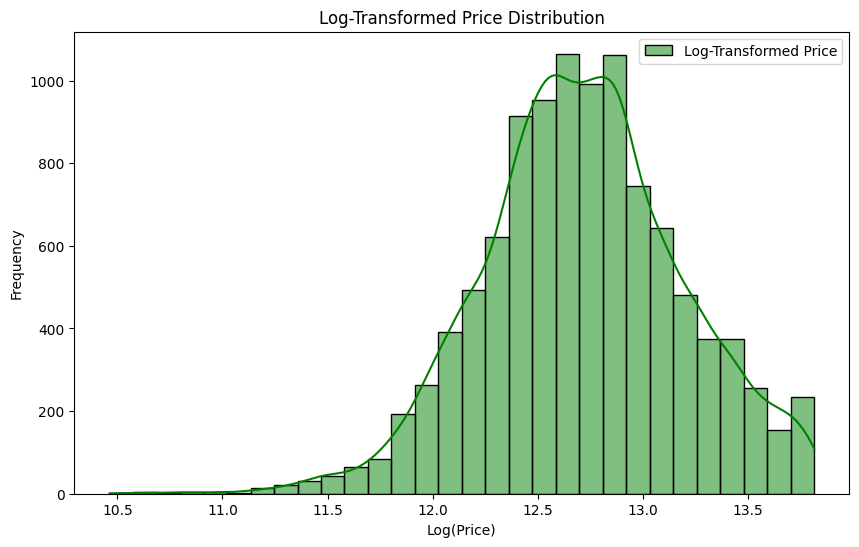

In [144]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Log_Price'], kde=True, bins=30, color='green', label='Log-Transformed Price')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Original price modelling was skewed. Log transformation normalized the distribution.

Remember: Reverse log transformation when interpreting - np.expm1()


In [145]:
X = df.drop(columns=['Log_Price', 'Price'])
y = df['Log_Price']

In [ ]:

model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [147]:
log_predictions = model.predict(X_test)
y_pred = np.expm1(log_predictions) 

In [148]:
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(np.expm1(y_test), y_pred)
print(f'R² Score: {r2}')

Root Mean Squared Error: 123768.52533107791
R² Score: 0.5375829316033593


Log price decreased score.

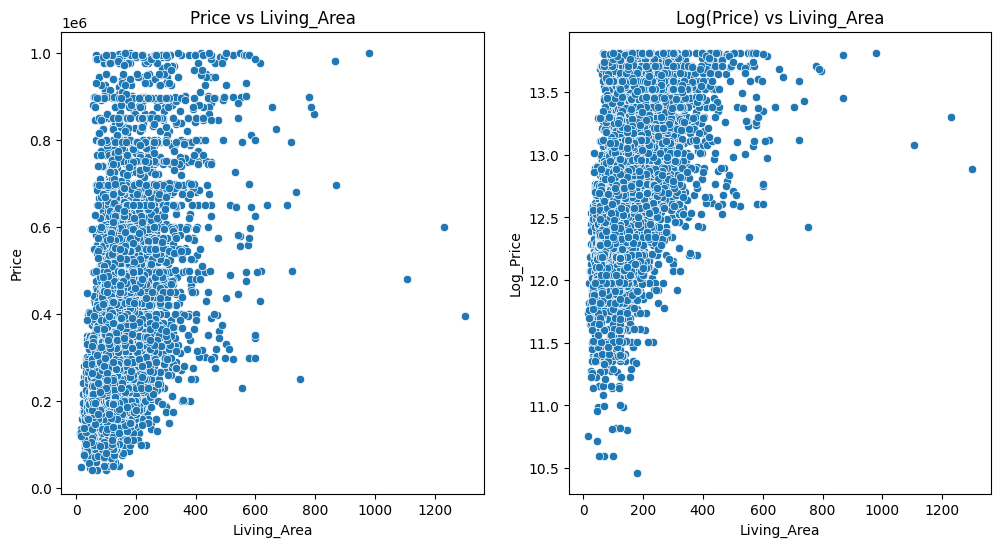

In [149]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['Living_Area'], y=df['Price'])
plt.title('Price vs Living_Area')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df['Living_Area'], y=df['Log_Price'])
plt.title('Log(Price) vs Living_Area')
plt.show()

In [150]:
train_score = model.score(X_train, y_train) * 100
test_score = model.score(X_test, y_test) * 100
print(f"Training Score: {train_score:.2f}")
print(f"Test Score: {test_score:.2f}")

Training Score: 70.06
Test Score: 57.10


In [151]:
df['Total_Outdoor_Area'] = df['Terrace_Area'] + df['Garden_Area']
df = df.drop(columns=['Terrace_Area', 'Garden_Area'])

In [152]:
X = df.drop(columns=['Log_Price', 'Price'])
y = df['Price']

In [ ]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [154]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Root Mean Squared Error: 121797.83993204936
R² Score: 0.5521912290813041


Score slightly decreased due to Aggregating outdoor areas.

In [159]:
df = df.drop(columns=['Total_Outdoor_Area', 'Log_Price'])

In [161]:
df['Log_Living_Area'] = np.log1p(df['Living_Area'])

In [165]:
X = df.drop(columns=['Price', 'Living_Area'])
y = df['Price']

In [166]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [167]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Root Mean Squared Error: 121797.83993204936
R² Score: 0.5521912290813041


No change from log transforming Living_Area

In [169]:
df = df.drop(columns=['Log_Living_Area'])
X = df.drop(columns=['Price'])
y = df['Price']

In [171]:
importances = model.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

              Feature  Importance
1         Living_Area    0.492836
4              Region    0.194255
2               State    0.124025
5  Total_Outdoor_Area    0.101481
0            Bedrooms    0.044141
3             Facades    0.043261


In [ ]:
df = df.drop(columns=['Facades', 'Bedrooms', ])
X = df.drop(columns=['Price'])
y = df['Price']

In [173]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [174]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Root Mean Squared Error: 121797.83993204936
R² Score: 0.5521912290813041


Dropping Facades and Bedroom has no effect.

Feature Engineering not yielding results - going to try Polynomial Features.

# Refresh df

In [176]:
df = pd.read_csv('immo-ml-data.csv')
df = df.drop(columns=['Type', 'Is_Equiped_Kitchen', 'Is_Open_Fire', 'Terrace', 'Garden', 'Swim_pool' ])
df.columns

Index(['Price', 'Bedrooms', 'Living_Area', 'Terrace_Area', 'Garden_Area',
       'State', 'Facades', 'Region'],
      dtype='object')

In [177]:
X = df.drop(columns=['Price'])
y = df['Price']

In [179]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [180]:
model_poly = RandomForestRegressor(max_depth=10, random_state=42)
model_poly.fit(X_train_poly, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [182]:
train_score = model_poly.score(X_train_poly, y_train)
test_score = model_poly.score(X_test_poly, y_test)

print(f"Training R²: {train_score:.2f}")
print(f"Test R²: {test_score:.2f}")

Training R²: 0.72
Test R²: 0.56


No meaningful improvement

Analyze residuals - Where is the model making the largest errors?

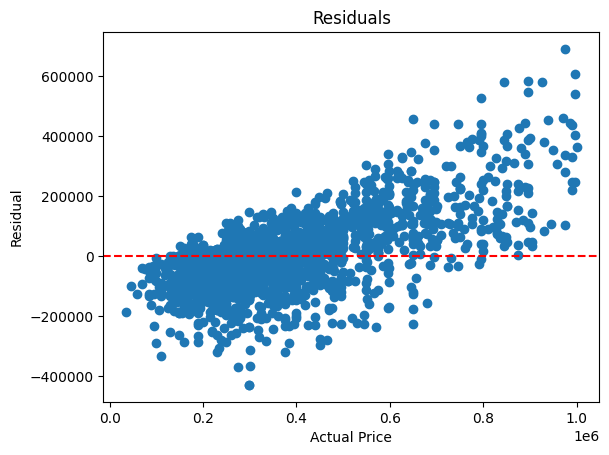

In [185]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Actual Price')
plt.ylabel('Residual')
plt.show()


Model struggles with hight prices

In [186]:
df['Price'] = df['Price'].clip(upper=df['Price'].quantile(0.99))


C:\Users\T570\AppData\Local\Temp\ipykernel_8320\2705779870.py:1: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Price'] = df['Price'].clip(upper=df['Price'].quantile(0.99))


In [187]:
X = df.drop(columns=['Price'])
y = df['Price']

In [ ]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    max_features='sqrt', # Minimal improvement
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42)

In [191]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Root Mean Squared Error: 121141.91301312021
R² Score: 0.5570014770307865


Try binning prices

In [ ]:
# Create 4 equal sized bins
df['Price_Bin'] = pd.qcut(df['Price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
print(df['Price_Bin'].value_counts())

Price_Bin
High         2641
Low          2628
Medium       2615
Very High    2601
Name: count, dtype: int64


In [193]:
for price_bin in df['Price_Bin'].unique():
    bin_data = df[df['Price_Bin'] == price_bin]
    
    # Define X and y for the specific bin
    X_bin = bin_data.drop(columns=['Price', 'Price_Bin'])
    y_bin = bin_data['Price']

In [194]:
X = df.drop(columns=['Price', 'Price_Bin'])
y = df['Price']

In [195]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['Price_Bin'], random_state=42
)

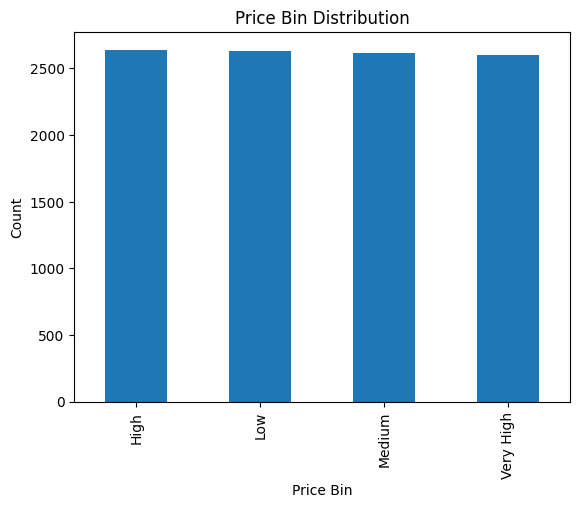

In [196]:
df['Price_Bin'].value_counts().plot(kind='bar')
plt.title('Price Bin Distribution')
plt.xlabel('Price Bin')
plt.ylabel('Count')
plt.show()


In [198]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=300,
                      random_state=42)

In [199]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R² Score: {r2:.2f}')

Root Mean Squared Error: 122273.46
R² Score: 0.54


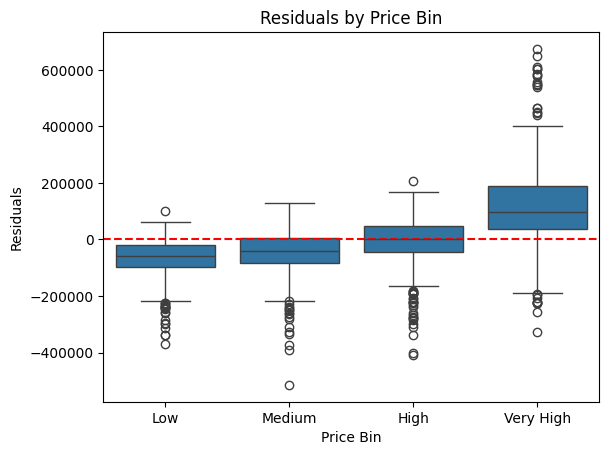

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
X_test['Residuals'] = X_test['Price'] - X_test['Prediction']

# Plot residuals by bin
sns.boxplot(x='Price_Bin', y='Residuals', data=X_test)
plt.title('Residuals by Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')  # Add a reference line for zero residuals
plt.show()



In [206]:
df. columns

Index(['Price', 'Bedrooms', 'Living_Area', 'Terrace_Area', 'Garden_Area',
       'State', 'Facades', 'Region', 'Price_Bin'],
      dtype='object')

In [210]:
X = df.drop(columns=['Price', 'Price_Bin'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['Price_Bin'], random_state=42)


In [211]:
model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    max_features='sqrt',
    random_state=42
)

weights = df.loc[X_train.index, 'Price_Bin'].map({'Low': 1, 'Medium': 1, 'High': 1, 'Very High': 2})

model.fit(X_train, y_train, sample_weight=weights)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42)

In [212]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R² Score: {r2:.2f}')

Root Mean Squared Error: 123409.92
R² Score: 0.53


Adding weight to the very high prices lowers score.

In [ ]:
df['Price_Bin'].value_counts(normalize=True)

Price_Bin
High         0.251884
Low          0.250644
Medium       0.249404
Very High    0.248069
Name: proportion, dtype: float64

I think I am missing key features for high-value properties. Not sure what I can do about it at this point.

0.57 seems like the highest score achievable with my current skillset.

**Edit:** Managed to get score up to 0.63 by adding avg_income